In [1]:
! gh issue list --repo expectedparrot/edsl --state open --limit 1000 --json number,title,state,createdAt,author,body,labels --jq '.[] | [.number, .title, .state, .createdAt, .author.login, (.labels | map(.name) | join(";")), .body] | @csv' > edsl_open_issues.csv

In [2]:
! gh issue list --repo expectedparrot/edsl --state open --limit 1000 --json number,title,state,createdAt,author,body,labels --jq '(["Number","Title","State","Created","Author","Labels","Body"] | @csv), (.[] | [.number, .title, .state, .createdAt, .author.login, (.labels | map(.name) | join(";")), .body] | @csv)' > edsl_open_issues.csv

In [17]:
from edsl import ScenarioList 
sl = ScenarioList.from_source("csv", "edsl_open_issues.csv")

In [18]:
sl[10]

key,value
author,rbyh
body,"Eg you may want ""Other"", ""None"" etc to always appear at the end of the list."
created,2025-11-02T15:18:13Z
labels,enhancement
number,2311
state,OPEN
title,Modify `Survey` param `questions_to_randomize` to allow you to specify options to not randomize


In [19]:
len(sl.filter("labels == 'bug'"))

23

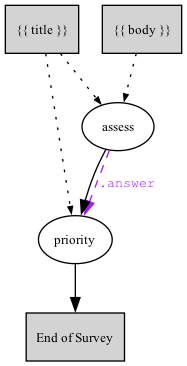

/Users/johnhorton/tools/ep/edsl/edsl/invigilators/question_instructions_prompt_builder.py:254: UserWarning: Question instructions still has variables: ['user_id_question'].
  warn(f"Question instructions still has variables: {undefined_vars}.")
/Users/johnhorton/tools/ep/edsl/edsl/questions/question_base_gen_mixin.py:110: UserWarning: Failed to render string: The open-sourced package EDSL is a tool 
for doing AI-powered social science research. It has an open issue on github. 
The title is {{ title }} 
and the description is {{ body }}. 

Please write about how this issue could affect the user experience, 
focusing on ways it would degrade that experience and how severe it might be.

  warnings.warn("Failed to render string: " + value)
/Users/johnhorton/tools/ep/edsl/edsl/invigilators/question_instructions_prompt_builder.py:254: UserWarning: Question instructions still has variables: ['topic', 'persona'].
  warn(f"Question instructions still has variables: {undefined_vars}.")
/Users/jo

In [20]:
from edsl import QuestionFreeText, QuestionLinearScale, Survey
q_assess = QuestionFreeText(question_text = """The open-sourced package EDSL is a tool 
for doing AI-powered social science research. It has an open issue on github. 
The title is {{ title }} 
and the description is {{ body }}. 

Please write about how this issue could affect the user experience, 
focusing on ways it would degrade that experience and how severe it might be.
""", 
question_name = "assess")

q_score = QuestionLinearScale(question_text = """The open-sourced package EDSL is a tool 
for doing AI-powered social science research. It has an open issue on github. 
The impact of the issue: `{{ title }}` on users was determined to be: {{ assess.answer }}. 
Please score this issue to help with prioritization.

About 20% of issues should be 1, 
About 30% of issues should be 2. 
About 50% of issues should be 3.
""",
        question_options = [1,2,3],
        option_labels = {
            1: "Tool is fundamentally unusable; affects security and safety",
            2: "Degrades user ability to do useful work; creates confusion",
            3: "An annoyance that will cause problems but users can mostly work around."},
        question_name = "priority")
survey = Survey([q_assess, q_score])
survey.show_flow()

results = survey.by(sl.filter("labels == 'bug'")).run(verbose = False, 
                                                      stop_on_exception = True,
                                                      disable_remote_inference = True)

In [7]:
results = survey.by(sl.filter("labels == 'bug'")).run(verbose = False, 
                                                      stop_on_exception = True,
                                                      disable_remote_inference = True)

In [21]:
results.select("answer.*")

answer.assess,answer.priority
"The exception deserialization issue in the EDSL package could significantly impact the user experience, particularly for those using the tool for AI-powered social science research. Here's how this issue could degrade the user experience and the potential severity of the impact: 1. **Interruption of Workflow:** - **Degradation:** Users might experience interruptions during their research workflows if exceptions cannot be properly deserialized. This could halt data processing or analysis tasks, leading to delays. - **Severity:** High, especially during critical phases of research or when working with tight deadlines. 2. **Loss of Diagnostic Information:** - **Degradation:** If exceptions are not accurately reconstructed, users may lose valuable diagnostic information necessary for debugging and understanding what went wrong during execution. - **Severity:** Moderate to high, as this could lead to increased time spent on troubleshooting and resolving issues without clear guidance. 3. **Increased Complexity:** - **Degradation:** Users might have to manually handle exceptions or implement workarounds, increasing the complexity of using the tool and potentially introducing more errors. - **Severity:** Moderate, as it adds an additional burden on users, particularly those who may not have a strong programming background. 4. **Inconsistent Behavior:** - **Degradation:** The tool may behave inconsistently if some exceptions are handled correctly while others lead to generic fallbacks, resulting in unpredictable outcomes. - **Severity:** Moderate, as it can lead to confusion and lack of trust in the tool's reliability. 5. **Compatibility Issues:** - **Degradation:** Users working with different versions of EDSL might face compatibility issues due to changes in exception handling, leading to version lock-in or the need for version-specific workarounds. - **Severity:** Moderate to high, as it can limit the flexibility of using the tool across different environments or with collaborators. Overall, the severity of the impact depends on the specific context in which users are employing EDSL. For users relying heavily on automated exception handling for large-scale or time-sensitive projects, the impact could be quite severe. Implementing the recommended fix would help mitigate these issues by ensuring exceptions are handled gracefully, preserving both functionality and user confidence in the tool.",2
"The open issue on GitHub for the EDSL package highlights several problems that could significantly degrade the user experience for those utilizing this tool for AI-powered social science research. Let's examine each problem and its potential impact: 1. **Missing Notebooks in the Sidebar:** - **Impact on User Experience:** Notebooks are often crucial components of documentation, especially for packages that involve complex functionalities like AI and social science research. They typically provide users with examples, tutorials, and practical demonstrations of how to use the package effectively. The absence of these notebooks in the sidebar makes it difficult for users to find and access this essential information. - **Severity:** High. This issue can lead to confusion and frustration, particularly for new users or those less familiar with the package. Without easy access to notebooks, users might struggle to understand how to implement the package's features, potentially leading to a steep learning curve and reduced adoption of the tool. 2. **Scenarios Page Not Loading:** - **Impact on User Experience:** The scenarios page likely contains specific use cases or examples that demonstrate the package's capabilities in real-world applications. If this page is not loading, users are deprived of valuable insights and practical guidance on how to apply the package in their research. - **Severity:** Moderate to High. While users might still be able to use the package without this page, the lack of accessible scenarios ca

In [9]:
from edsl import ScenarioList 
sl = ScenarioList.from_list('fruit', ['apple', 'cherry', 'banana', 'date', 'orange', "stink berry"])

In [10]:
sl.create_comparisons()

option_1_fruit,option_2_fruit
apple,cherry
apple,banana
apple,date
apple,orange
apple,stink berry
cherry,banana
cherry,date
cherry,orange
cherry,stink berry
banana,date


In [11]:
from edsl import QuestionMultipleChoice
q = QuestionMultipleChoice(question_name = "fruit_pref", 
                           question_text = """Which fruit to you prefer: 
                           option_1: {{ scenario.option_1}}
                           option_2: {{ scenario.option_2}}?""",
                           question_options = ["option_1", "option_2"], 
                          )
results = q.by(sl.create_comparisons()).run(verbose = False)

/Users/johnhorton/tools/ep/edsl/edsl/invigilators/question_instructions_prompt_builder.py:254: UserWarning: Question instructions still has variables: ['option_1', 'option_2'].
  warn(f"Question instructions still has variables: {undefined_vars}.")


In [12]:
results.select('fruit_pref', 'option_1', 'option_2')

answer.fruit_pref,scenario.option_1_fruit,scenario.option_2_fruit
option_1,apple,cherry
option_1,apple,banana
option_1,apple,date
option_1,apple,orange
option_1,apple,stink berry
option_1,cherry,banana
option_1,cherry,date
option_1,cherry,orange
option_1,cherry,stink berry
option_1,banana,date


In [13]:
import itertools
from typing import List, Dict, Tuple, Any
from collections import defaultdict

def find_optimal_ranking(preferences: List[Dict[str, Any]]) -> Tuple[List[str], int]:
    """
    Find the optimal ranking with minimal transitivity violations from preference data.
    
    Parameters:
    -----------
    preferences : List[Dict[str, Any]]
        List of preference data. Each dictionary should have:
        - 'options': List of options presented (strings)
        - 'chosen': The chosen option (string)
        
    Returns:
    --------
    Tuple[List[str], int]
        A tuple containing:
        - The optimal ranking as a list (most preferred to least preferred)
        - The number of transitivity violations in this ranking
    """
    # Extract all unique items
    all_items = set()
    
    # Build pairwise comparisons from the preferences
    comparisons = []
    for pref in preferences:
        options = pref['options']
        chosen = pref['chosen']
        
        if chosen not in options:
            raise ValueError(f"Chosen option '{chosen}' not in available options: {options}")
            
        # Add all items to our set
        all_items.update(options)
        
        # Create pairwise comparisons: chosen > each other option
        for option in options:
            if option != chosen:
                comparisons.append((chosen, option))  # chosen is preferred over option
    
    # Convert set to list for consistent ordering
    all_items = list(all_items)
    
    # Build a directed graph of preferences
    graph = {item: {'wins': 0, 'losses': 0, 'against': defaultdict(int)} for item in all_items}
    
    for winner, loser in comparisons:
        graph[winner]['wins'] += 1
        graph[loser]['losses'] += 1
        graph[winner]['against'][loser] += 1
    
    # Calculate win percentages
    for item in graph:
        total_games = graph[item]['wins'] + graph[item]['losses']
        graph[item]['win_pct'] = graph[item]['wins'] / total_games if total_games > 0 else 0
    
    # Function to count transitivity violations for a given ranking
    def count_violations(ranking: List[str]) -> int:
        violations = 0
        for i in range(len(ranking)):
            for j in range(i + 1, len(ranking)):
                higher_ranked = ranking[i]
                lower_ranked = ranking[j]
                
                # Check if lower-ranked beat higher-ranked item
                if graph[lower_ranked]['against'][higher_ranked] > 0:
                    violations += graph[lower_ranked]['against'][higher_ranked]
        
        return violations
    
    # For a small number of items, try all permutations
    if len(all_items) <= 8:  # Limit for performance reasons (8! = 40,320 permutations)
        best_ranking = None
        min_violations = float('inf')
        
        for perm in itertools.permutations(all_items):
            violations = count_violations(perm)
            if violations < min_violations:
                min_violations = violations
                best_ranking = list(perm)
        
        return best_ranking, min_violations
    
    # For larger sets, use heuristic rankings and pick the best
    heuristic_rankings = [
        # By win percentage
        sorted(all_items, key=lambda x: graph[x]['win_pct'], reverse=True),
        # By total wins
        sorted(all_items, key=lambda x: graph[x]['wins'], reverse=True),
        # By net wins (wins - losses)
        sorted(all_items, key=lambda x: graph[x]['wins'] - graph[x]['losses'], reverse=True)
    ]
    
    best_ranking = None
    min_violations = float('inf')
    
    for ranking in heuristic_rankings:
        violations = count_violations(ranking)
        if violations < min_violations:
            min_violations = violations
            best_ranking = ranking
    
    return best_ranking, min_violations


def convert_pairwise_to_preferences(pairwise_data: List[Dict[str, Any]]) -> List[Dict[str, Any]]:
    """
    Convert pairwise comparison data to the standard preference format.
    
    Parameters:
    -----------
    pairwise_data : List[Dict[str, Any]]
        List of pairwise comparison data. Each dictionary should have:
        - 'option1': First option
        - 'option2': Second option
        - 'choice': Either 'option1' or 'option2' indicating which was chosen
        
    Returns:
    --------
    List[Dict[str, Any]]
        Preference data in the standard format for find_optimal_ranking
    """
    preferences = []
    
    for pair in pairwise_data:
        option1 = pair['option1']
        option2 = pair['option2']
        choice = pair['choice']
        
        chosen = option1 if choice == 'option1' else option2
        
        preferences.append({
            'options': [option1, option2],
            'chosen': chosen
        })
    
    return preferences


def convert_ranked_to_preferences(ranked_data: List[Dict[str, Any]]) -> List[Dict[str, Any]]:
    """
    Convert ranked list data to the standard preference format.
    
    Parameters:
    -----------
    ranked_data : List[Dict[str, Any]]
        List of ranked data. Each dictionary should have:
        - 'options': List of options presented
        - 'ranking': List of options in ranked order (most to least preferred)
        
    Returns:
    --------
    List[Dict[str, Any]]
        Preference data in the standard format for find_optimal_ranking
    """
    preferences = []
    
    for rank_data in ranked_data:
        options = rank_data['options']
        ranking = rank_data['ranking']
        
        # Generate all pairwise preferences from the ranking
        for i in range(len(ranking)):
            preferred = ranking[i]
            
            for j in range(i + 1, len(ranking)):
                less_preferred = ranking[j]
                
                # Only include if both items were in the original options
                if preferred in options and less_preferred in options:
                    preferences.append({
                        'options': [preferred, less_preferred],
                        'chosen': preferred
                    })
    
    return preferences


def convert_pandas_df_to_preferences(df, 
                              pref_col='answer.fruit_pref', 
                              option1_col='scenario.option_1', 
                              option2_col='scenario.option_2'):
    """
    Convert a pandas DataFrame with preference data to the standard preference format.
    
    Parameters:
    -----------
    df : pandas.DataFrame
        DataFrame containing preference data
    pref_col : str
        Column name that indicates which option was chosen (e.g., 'answer.fruit_pref')
    option1_col : str
        Column name for the first option (e.g., 'scenario.option_1')
    option2_col : str
        Column name for the second option (e.g., 'scenario.option_2')
        
    Returns:
    --------
    List[Dict[str, Any]]
        Preference data in the standard format for find_optimal_ranking
    """
    preferences = []
    
    for _, row in df.iterrows():
        # Extract option values
        option1_val = extract_value_from_dict_str(row[option1_col])
        option2_val = extract_value_from_dict_str(row[option2_col])
        
        # Determine which option was chosen
        chosen = option1_val if row[pref_col] == 'option_1' else option2_val
        
        preferences.append({
            'options': [option1_val, option2_val],
            'chosen': chosen
        })
    
    return preferences


def extract_value_from_dict_str(dict_str):
    """
    Extract value from a dictionary-like string such as "{'fruit': 'apple'}"
    
    Parameters:
    -----------
    dict_str : str or dict
        Dictionary-like string or actual dictionary
        
    Returns:
    --------
    str
        The extracted value
    """
    # If it's already a dictionary
    if isinstance(dict_str, dict):
        if 'fruit' in dict_str:
            return dict_str['fruit']
        return next(iter(dict_str.values()))  # Return first value
    
    # If it's a string representation of a dictionary
    if isinstance(dict_str, str) and "'" in dict_str:
        # Simple parsing for common format {'key': 'value'}
        parts = dict_str.split("'")
        if len(parts) >= 4:
            return parts[3]  # This should be the value
    
    # If all else fails, return as is
    return dict_str


# Example usage
if __name__ == "__main__":
    
    
    df = results.select('fruit_pref', 'option_1', 'option_2').to_pandas()
    preferences = convert_pandas_df_to_preferences(df)
    
    # Find optimal ranking
    optimal_ranking, violations = find_optimal_ranking(preferences)
    print(f"Optimal ranking from pandas DataFrame: {optimal_ranking}")
    print(f"Number of transitivity violations: {violations}")


KeyError: 'scenario.option_1'

In [ ]:
from edsl import Notebook
nb = Notebook(path = "PairwiseComparisonsDemo.ipynb")

In [ ]:
if refresh := False:
    nb.push(visibility = "public", 
        alias = "pairwise-comparisons", 
        description = "Turn scenario into pariwise comparisons")
else:
    nb.patch('8d67b02d-06db-41f2-ac0d-87249e66a0d3')

In [ ]:
survey.show_flow()